In [1]:
import numpy as np
import secrets
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Early: tasks_dict =  dict_items([('01111110', [3, 11, 3, 3, 11]), ('10100110', [9, 2, 2, 1, 1]), ('10101111', [2, 9, 8, 4, 11]), ('11110001', [3, 4, 3, 8, 9]), ('11100000', [1, 0, 10, 6, 5]), ('00011100', [5, 9, 7, 8, 4])])


100%|██████████| 1000/1000 [33:51<00:00,  2.03s/it]


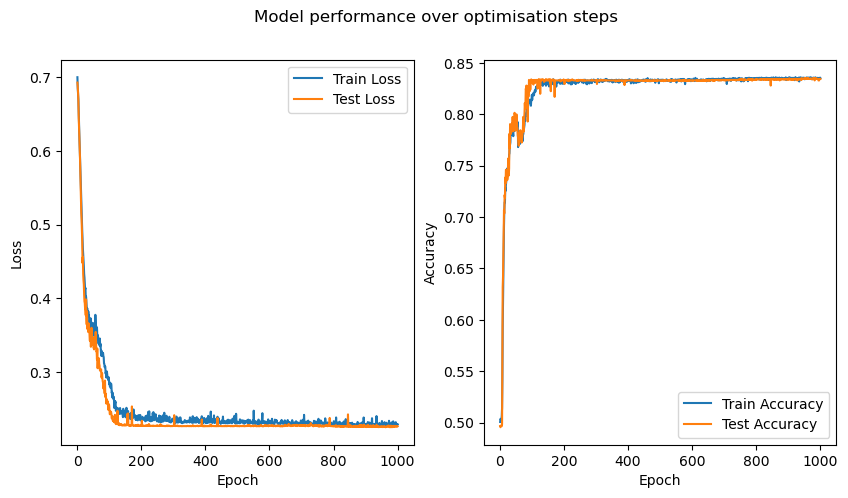

Total model parameters = 529


In [54]:
# Parameters
n_tasks = 6 # number of tasks created
len_taskcode = 8 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 5  # Length of the associated integer list for each task. Must be less than len_message
len_message = 12  # Maximum integer value in the associated integer list
num_samples = 10000 # number of samples created in the dataset
samples_per_task = 1000
# Define hyperparameters
input_size = len_taskcode + len_message
output_size = 1
learning_rate = 0.005
batch_size = 32
num_epochs = 1000
test_frac = 0.2
num_layers = 6
hidden_size = 8

def generate_random_binary_string(length):
    binary_string = ''.join(secrets.choice(['0', '1']) for _ in range(length))
    return binary_string

def generate_dict(n_tasks, len_taskcode, num_checks, len_message):
    unique_strings = set()
    tasks_dict = {}

    while len(unique_strings) < n_tasks:
        binary_string = generate_random_binary_string(len_taskcode)

        if binary_string not in unique_strings:
            unique_strings.add(binary_string)

            integer_list = [secrets.randbelow(len_message) for _ in range(num_checks)]
            tasks_dict[binary_string] = integer_list

    return tasks_dict

tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message)
print("Early: tasks_dict = ", tasks_dict.items())

def generate_dataset(tasks_dict, num_samples):
  data = np.zeros((num_samples, len_taskcode + len_message))
  value = np.zeros(num_samples)
  for i in range(num_samples):
    rand_task = np.random.choice(list(tasks_dict))
    rand_checkbits = tasks_dict[rand_task]
    message = generate_random_binary_string(len_message)
    parity_bit = 0
    for j in rand_checkbits:
      parity_bit += int(message[j])
    parity = parity_bit % 2
    data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
    value[i] = parity
  return [data, value]

def generate_dataset_for_task(task_code, num_samples):
  data = np.zeros((num_samples, len_taskcode + len_message))
  value = np.zeros(num_samples)
  for i in range(num_samples):
    rand_task = task_code
    rand_checkbits = tasks_dict[rand_task]
    message = generate_random_binary_string(len_message)
    parity_bit = 0
    for j in rand_checkbits:
      parity_bit += int(message[j])
    parity = parity_bit % 2
    data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
    value[i] = parity
  return [data, value]

[data, value] = generate_dataset(tasks_dict, num_samples)

# Create a dataframe for training
df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])

'''
# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        
        self.layers.append(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        
        x = self.layers[-1](x)
        return x
'''
# Define a NN class WITH BATCH NORMALISATION
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(NeuralNetwork, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))  # Additional linear layer
        
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.BatchNorm1d(hidden_size))  # Add BatchNorm1d layer
        
        self.layers.append(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            if i == 0:  # Apply ReLU activation only after the additional linear layer
                x = F.relu(layer(x))
            else:
                x = layer(x)
                if i % 2 == 0:
                    x = F.relu(x)  # Apply ReLU activation after each linear layer
        x = self.layers[-1](x)
        return x

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.iloc[:, :-1].values
        self.target = dataframe.iloc[:, -1].values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()
        y = torch.tensor(self.target[idx]).float()
        return x, y

# Split the data into training and test sets
#train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)
train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)

# Create instances of the neural network
model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)

# Define loss function and optimizer (same as before)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Create DataLoaders for the training and test data
train_dataset = CustomDataset(train_df)
test_dataset = CustomDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_loss_list = np.empty(num_epochs)
test_loss_list = np.empty(num_epochs)

train_accuracy_list = np.empty(num_epochs)
test_accuracy_list = np.empty(num_epochs)

accuracy_array = np.zeros((n_tasks, num_epochs)) # such that each row is the accuracy for that specific task over all epochs

# Train the model
for epoch in tqdm(range(num_epochs)):
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    model.train()
    
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels.unsqueeze(1))

        # Compute predictions
        predictions = (outputs >= 0.5).squeeze().long()
        
        # Compute accuracy
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    # Calculate average train loss
    train_loss = train_loss / len(train_dataset)
    # Calculate average train accuracy
    train_accuracy = train_correct / train_total
    
    # Evaluate the model on the test set
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            # Compute predictions
            predictions = (outputs >= 0.5).squeeze().long()
            
            # Compute accuracy
            test_correct += (predictions == labels).sum().item()
            test_total += labels.size(0)

            loss = criterion(outputs, labels.unsqueeze(1))
            test_loss += loss.item() * inputs.size(0)

            '''
            predictions_task = np.empty(n_tasks)
            totals = np.empty(n_tasks)
            # Finding the accuracy per task. Not very efficiently programmed
            # Find the first len_taskcode bits of each input
            for i, input in enumerate(inputs):
              beginning = input[0:len_taskcode]
              beginning_list = beginning.numpy().tolist()
              beginning_string = ''.join([str(int(element)) for element in beginning_list])
              keys_list = list(tasks_dict.keys())
              index = keys_list.index(beginning_string) #this index is the dictionary index corresponding to the input being considered
              #print(f"index = ", index)
              prediction = predictions[i] # the output relevant to the input element
              #print(f"prediction = ", prediction.numpy())
              #accuracy_array[index, epoch] += 
            '''
        # Calculate average test loss
        test_loss = test_loss / len(test_dataset)

    # Calculate average test accuracy
    test_accuracy = test_correct / test_total
    
    # Update the loss lists
    train_loss_list[epoch] = train_loss
    test_loss_list[epoch] = test_loss

    train_accuracy_list[epoch] = train_accuracy
    test_accuracy_list[epoch] = test_accuracy

    # Find accuracy data
    tasks_list = list(tasks_dict.keys())
    for i in range(n_tasks):
      task_code = tasks_list[i]
      #print(f"task_code = ", task_code)
      [data_per_task, value_per_task] = generate_dataset_for_task(task_code, samples_per_task)
      #print(data_per_task)
      df_per_task = pd.DataFrame(np.concatenate((data_per_task, value_per_task.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])
      #print(df_per_task)
      dataset_per_task = CustomDataset(df_per_task)
      loader_per_task = DataLoader(dataset_per_task, batch_size=batch_size, shuffle=True)
      model.eval()
      task_correct = 0
      task_total = 0
      with torch.no_grad():
        for inputs, labels in loader_per_task:
            outputs = model(inputs)
            # Compute predictions
            predictions = (outputs >= 0.5).squeeze().long()
            
            # Compute accuracy
            task_correct += (predictions == labels).sum().item()
            task_total += labels.size(0)
            #print(f'inputs = ', inputs)
            #print(f'labels.size(0) = ', labels.size(0))

            #loss = criterion(outputs, labels.unsqueeze(1)) #if in future I want to calculate loss
            #test_loss += loss.item() * inputs.size(0)
        task_accuracy = task_correct / task_total
        #print(f"task_accuracy = ", task_accuracy)
        accuracy_array[(i, epoch)] = task_accuracy
    #print(f"accuracy_array = {accuracy_array} at epoch {epoch}")
    # Print epoch information
    #print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}")


# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the training and test losses on the first subplot
axs[0].plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
axs[0].plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot the training and test accuracies on the second subplot
axs[1].plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
axs[1].plot(range(1, num_epochs+1), test_accuracy_list, label='Test Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust the spacing between subplots
#plt.tight_layout()
plt.suptitle('Model performance over optimisation steps')
# Show the subplots
plt.show()

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters = {pytorch_total_params}")

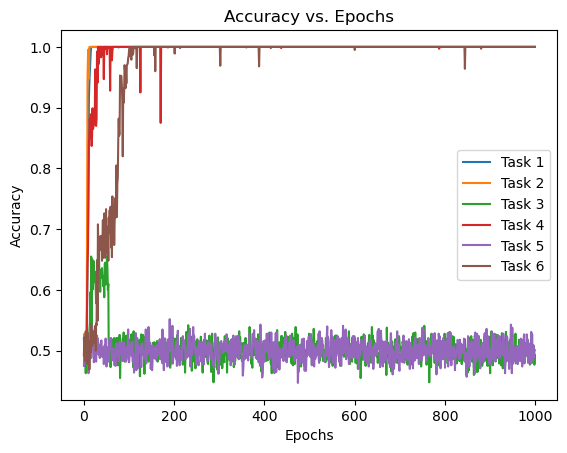

In [56]:
# Plotting accuracy by task. Note that this is all on separate data sets, so should be treated as test set

# Plotting each array with its corresponding index as the label
for i in range(n_tasks):
    plt.plot(np.arange(0, num_epochs, 1), accuracy_array[i], label='Task ' + str(i+1))

# Add plot labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

# Show the plot
plt.show()

C:\Users\plogo\AppData\Local\Temp\ipykernel_10932\2908889953.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.arange(1, n_tasks + 1, 1), label='Task Number')


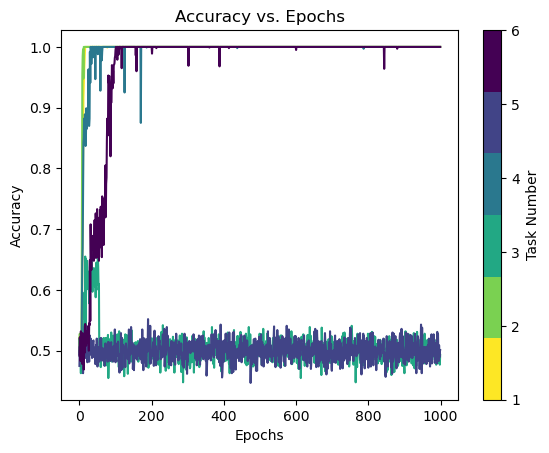

In [55]:
# Colourmap plotting accuracy by task

# Define the colourmap
color_map = plt.cm.get_cmap('viridis_r', n_tasks)

# Plotting each array with its corresponding index as the label and color
for i in range(n_tasks):
    plt.plot(np.arange(0, num_epochs, 1), accuracy_array[i], label='Task ' + str(i+1), color=color_map(i))

# Add plot labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
#plt.legend()

# Create a colorbar indicating the task numbers
sm = plt.cm.ScalarMappable(cmap=color_map)
sm.set_array(range(1, n_tasks + 1))
plt.colorbar(sm, ticks=np.arange(1, n_tasks + 1, 1), label='Task Number')

# Show the plot
plt.show()

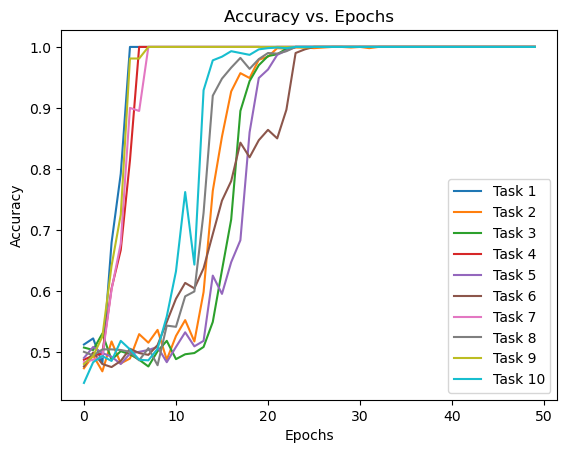

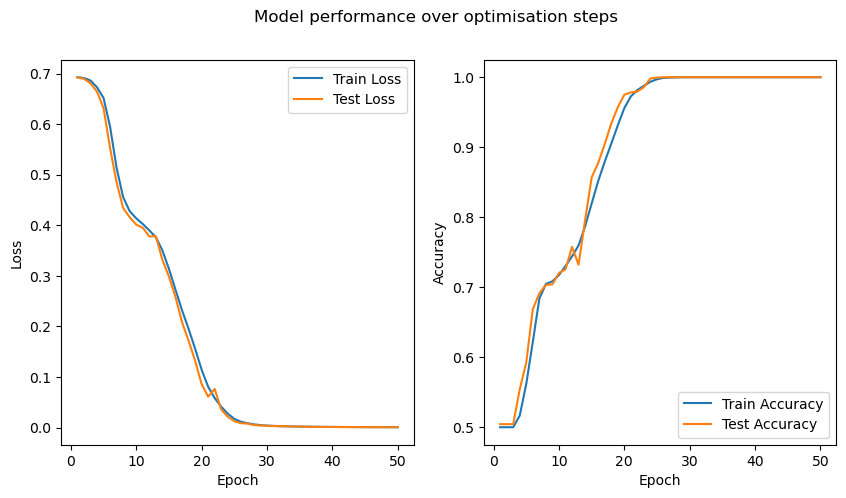

Total model parameters = 2753


In [9]:
# Produce a plot with the prior data, up to num_epochs epochs. 
# Reusing num_epochs is annoying, but the most efficient way to reuse code

num_epochs = 50

for i in range(n_tasks):
    plt.plot(np.arange(0, num_epochs, 1), accuracy_array[i][0:num_epochs], label='Task ' + str(i+1))

# Add plot labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

# Show the plot
plt.show()

plt.close()

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the training and test losses on the first subplot
axs[0].plot(range(1, num_epochs+1), train_loss_list[0:num_epochs], label='Train Loss')
axs[0].plot(range(1, num_epochs+1), test_loss_list[0:num_epochs], label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot the training and test accuracies on the second subplot
axs[1].plot(range(1, num_epochs+1), train_accuracy_list[0:num_epochs], label='Train Accuracy')
axs[1].plot(range(1, num_epochs+1), test_accuracy_list[0:num_epochs], label='Test Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust the spacing between subplots
#plt.tight_layout()
plt.suptitle('Model performance over optimisation steps')
# Show the subplots
plt.show()

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters = {pytorch_total_params}")

In [31]:
# Store variables from a previous run

# CAUTION - DO NOT RUN: THIS WILL ERASE THE COPIED DATA

train_loss_copy = train_loss_list
test_loss_copy = test_loss_list
train_accuracy_copy = train_accuracy_list
test_accuracy_copy = test_accuracy_list
accuracy_array_copy = accuracy_array

100%|██████████| 100/100 [1:02:47<00:00, 37.67s/it]


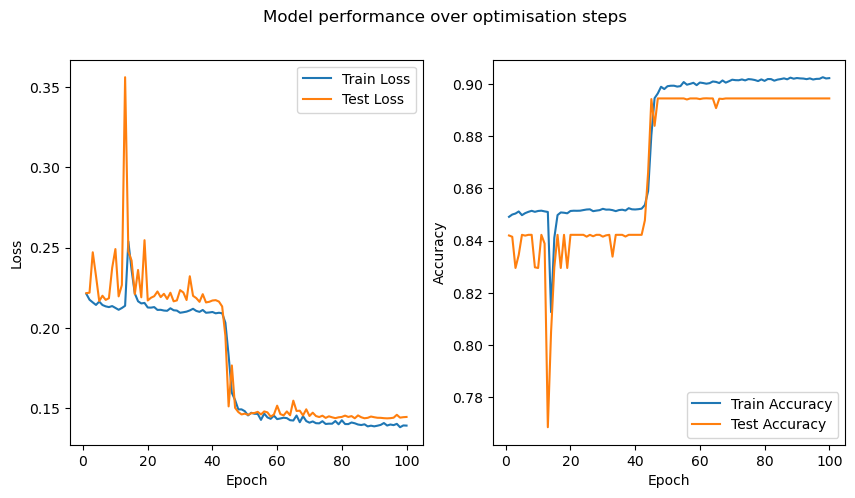

Total model parameters = 11841


In [32]:
# Continue training. Same dataset, same model, same everything. Should be simply a continuation of what you see above.

num_epochs = 100 #number of additional epochs intended

train_loss_list = np.empty(num_epochs)
test_loss_list = np.empty(num_epochs)

train_accuracy_list = np.empty(num_epochs)
test_accuracy_list = np.empty(num_epochs)

accuracy_array = np.zeros((n_tasks, num_epochs)) # such that each row is the accuracy for that specific task over all epochs

# Train the model
for epoch in tqdm(range(num_epochs)):
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    model.train()
    
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels.unsqueeze(1))

        # Compute predictions
        predictions = (outputs >= 0.5).squeeze().long()
        
        # Compute accuracy
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    # Calculate average train loss
    train_loss = train_loss / len(train_dataset)
    # Calculate average train accuracy
    train_accuracy = train_correct / train_total
    
    # Evaluate the model on the test set
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            # Compute predictions
            predictions = (outputs >= 0.5).squeeze().long()
            
            # Compute accuracy
            test_correct += (predictions == labels).sum().item()
            test_total += labels.size(0)

            loss = criterion(outputs, labels.unsqueeze(1))
            test_loss += loss.item() * inputs.size(0)

        # Calculate average test loss
        test_loss = test_loss / len(test_dataset)

    # Calculate average test accuracy
    test_accuracy = test_correct / test_total
    
    # Update the loss lists
    train_loss_list[epoch] = train_loss
    test_loss_list[epoch] = test_loss

    train_accuracy_list[epoch] = train_accuracy
    test_accuracy_list[epoch] = test_accuracy

    # Find accuracy data
    tasks_list = list(tasks_dict.keys())
    for i in range(n_tasks):
      task_code = tasks_list[i]
      #print(f"task_code = ", task_code)
      [data_per_task, value_per_task] = generate_dataset_for_task(task_code, samples_per_task)
      #print(data_per_task)
      df_per_task = pd.DataFrame(np.concatenate((data_per_task, value_per_task.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])
      #print(df_per_task)
      dataset_per_task = CustomDataset(df_per_task)
      loader_per_task = DataLoader(dataset_per_task, batch_size=batch_size, shuffle=True)
      model.eval()
      task_correct = 0
      task_total = 0
      with torch.no_grad():
        for inputs, labels in loader_per_task:
            outputs = model(inputs)
            # Compute predictions
            predictions = (outputs >= 0.5).squeeze().long()
            
            # Compute accuracy
            task_correct += (predictions == labels).sum().item()
            task_total += labels.size(0)
            #print(f'inputs = ', inputs)
            #print(f'labels.size(0) = ', labels.size(0))

            #loss = criterion(outputs, labels.unsqueeze(1)) #if in future I want to calculate loss
            #test_loss += loss.item() * inputs.size(0)
        task_accuracy = task_correct / task_total
        #print(f"task_accuracy = ", task_accuracy)
        accuracy_array[(i, epoch)] = task_accuracy
    #print(f"accuracy_array = {accuracy_array} at epoch {epoch}")
    # Print epoch information
    #print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}")


# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the training and test losses on the first subplot
axs[0].plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
axs[0].plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot the training and test accuracies on the second subplot
axs[1].plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
axs[1].plot(range(1, num_epochs+1), test_accuracy_list, label='Test Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust the spacing between subplots
#plt.tight_layout()
plt.suptitle('Model performance over optimisation steps')
# Show the subplots
plt.show()

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters = {pytorch_total_params}")

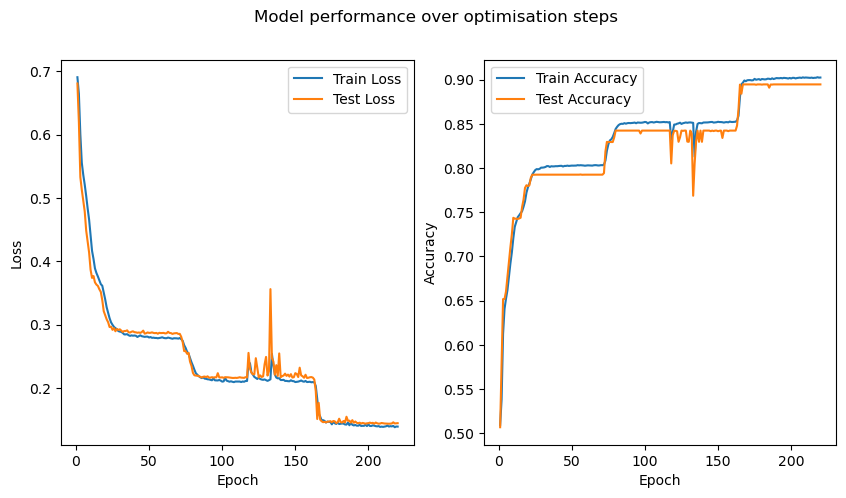

Total model parameters = 11841


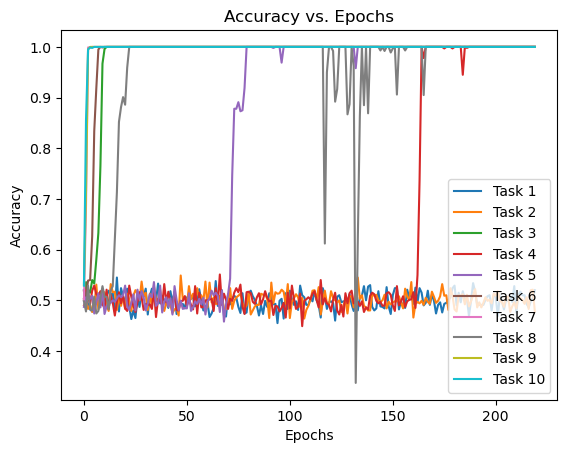

In [37]:
# Concatenating old and new results

num_epochs = 220

full_train_loss = np.concatenate((train_loss_copy, train_loss_list))
full_test_loss = np.concatenate((test_loss_copy,test_loss_list))
full_train_accuracy = np.concatenate((train_accuracy_copy,train_accuracy_list))
full_test_accuracy = np.concatenate((test_accuracy_copy, test_accuracy_list))

full_accuracy_array = np.zeros((n_tasks,num_epochs)) # 220 is the total number of epochs in the overall set
for index in range(len(full_accuracy_array)):
    full_accuracy_array[index] = np.concatenate((accuracy_array_copy[index], accuracy_array[index]))
    
# Plotting algorithms

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the training and test losses on the first subplot
axs[0].plot(range(1, num_epochs+1), full_train_loss, label='Train Loss')
axs[0].plot(range(1, num_epochs+1), full_test_loss, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot the training and test accuracies on the second subplot
axs[1].plot(range(1, num_epochs+1), full_train_accuracy, label='Train Accuracy')
axs[1].plot(range(1, num_epochs+1), full_test_accuracy, label='Test Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust the spacing between subplots
#plt.tight_layout()
plt.suptitle('Model performance over optimisation steps')
# Show the subplots
plt.show()

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters = {pytorch_total_params}")

# ACCURACY PER TASK PLOT
# Plotting each array with its corresponding index as the label
for i in range(n_tasks):
    plt.plot(np.arange(0, num_epochs, 1), full_accuracy_array[i], label='Task ' + str(i+1))

# Add plot labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

# Show the plot
plt.show()

dict_values([[6, 4, 2], [5, 3, 6], [2, 5, 4], [1, 7, 0], [3, 1, 7], [5, 4, 5], [7, 3, 5], [4, 1, 4], [1, 6, 2], [0, 3, 4], [4, 5, 3], [1, 0, 7], [1, 5, 1], [2, 4, 0], [5, 0, 1], [6, 7, 7], [6, 3, 5], [2, 2, 3], [5, 6, 7], [0, 1, 5], [2, 0, 2], [6, 6, 3], [7, 3, 6], [7, 6, 2], [1, 7, 1], [4, 7, 4], [4, 2, 4], [3, 2, 1], [2, 5, 5], [0, 7, 2], [1, 5, 7], [7, 7, 4], [0, 6, 5], [1, 0, 7], [7, 4, 6], [3, 5, 4], [7, 1, 0], [2, 5, 0], [7, 4, 1], [3, 6, 3], [6, 7, 1], [7, 0, 6], [2, 0, 5], [4, 4, 3], [1, 1, 1], [6, 1, 2], [4, 4, 6], [7, 6, 4], [7, 4, 3], [6, 2, 0], [0, 7, 4], [3, 1, 4], [0, 3, 3], [2, 1, 5], [6, 5, 0], [6, 3, 2], [4, 0, 1], [2, 3, 0], [6, 4, 2], [5, 6, 3], [5, 1, 6], [5, 4, 6], [3, 3, 1], [1, 3, 5], [6, 4, 1], [3, 0, 7], [7, 7, 2], [4, 7, 0], [7, 4, 7], [0, 5, 6], [1, 7, 3], [4, 1, 1], [1, 4, 1], [0, 7, 1], [5, 4, 1], [1, 5, 2], [2, 1, 5], [3, 2, 6], [4, 1, 7], [5, 5, 2], [7, 0, 6], [6, 0, 3], [6, 1, 6], [1, 0, 1], [2, 3, 1], [0, 4, 2], [4, 3, 5], [4, 7, 4], [4, 7, 1], [5, 3, 4